In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import csv
from pyspark.sql import SparkSession
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt 
from pyspark.sql.types import StructType, StructField, StringType
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()
import warnings
warnings.filterwarnings("ignore")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/24 21:42:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df=spark.read.csv("/Users/nithinkumar/Downloads/Daily Household Transactions.csv",header=True,inferSchema=True)

In [3]:
df.show(3)

+-------------------+--------------------+--------------+-----------+--------------------+------+--------------+--------+
|               Date|                Mode|      Category|Subcategory|                Note|Amount|Income/Expense|Currency|
+-------------------+--------------------+--------------+-----------+--------------------+------+--------------+--------+
|20/09/2018 12:04:08|                Cash|Transportation|      Train|2 Place 5 to Place 0|  30.0|       Expense|     INR|
|20/09/2018 12:03:15|                Cash|          Food|     snacks|Idli medu Vada mi...|  60.0|       Expense|     INR|
|         19/09/2018|Saving Bank accou...|  subscription|    Netflix|1 month subscription| 199.0|       Expense|     INR|
+-------------------+--------------------+--------------+-----------+--------------------+------+--------------+--------+
only showing top 3 rows



In [4]:
df.describe().show()

23/09/24 21:42:05 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------+--------------------+-------------------+-----------+----------------+------------------+--------------+--------+
|summary|    Date|                Mode|           Category|Subcategory|            Note|            Amount|Income/Expense|Currency|
+-------+--------+--------------------+-------------------+-----------+----------------+------------------+--------------+--------+
|  count|    2461|                2461|               2461|       1826|            1940|              2461|          2461|    2461|
|   mean|    null|                null|               null|       null|             2.0|2751.1453799268593|          null|    null|
| stddev|    null|                null|               null|       null|            null|12519.615804355946|          null|    null|
|    min|1/1/2015|                Cash|Amazon pay cashback|Accessories|         courier|               2.0|       Expense|     INR|
|    max|9/9/2017|Share Market Trading|water (jar /tanker)| vegetables|yevle

In [5]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Mode: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Subcategory: string (nullable = true)
 |-- Note: string (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Income/Expense: string (nullable = true)
 |-- Currency: string (nullable = true)



In [6]:
df.count()

2461

In [7]:
## Feature Engineering

In [8]:
from pyspark.sql.functions import split,substring
df=df.withColumn('Date_only',split(df['Date'],"/")[0])
df=df.withColumn('month',split(df['Date'],"/")[1])
df=df.withColumn('year',substring(split(df['Date'],"/")[2],1,4))
df=df.withColumn('hour',substring(split(split(df['Date'],"/")[2],' ')[1],1,2))

In [9]:
df.show(3)

+-------------------+--------------------+--------------+-----------+--------------------+------+--------------+--------+---------+-----+----+----+
|               Date|                Mode|      Category|Subcategory|                Note|Amount|Income/Expense|Currency|Date_only|month|year|hour|
+-------------------+--------------------+--------------+-----------+--------------------+------+--------------+--------+---------+-----+----+----+
|20/09/2018 12:04:08|                Cash|Transportation|      Train|2 Place 5 to Place 0|  30.0|       Expense|     INR|       20|   09|2018|  12|
|20/09/2018 12:03:15|                Cash|          Food|     snacks|Idli medu Vada mi...|  60.0|       Expense|     INR|       20|   09|2018|  12|
|         19/09/2018|Saving Bank accou...|  subscription|    Netflix|1 month subscription| 199.0|       Expense|     INR|       19|   09|2018|null|
+-------------------+--------------------+--------------+-----------+--------------------+------+--------------+

In [10]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Mode: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Subcategory: string (nullable = true)
 |-- Note: string (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Income/Expense: string (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Date_only: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- hour: string (nullable = true)



In [11]:
from pyspark.sql.functions import col
df=df.withColumns({'Date_only':col('Date_only').cast("int"),
                  'month':col('month').cast("int"),
                  'year':col('year').cast("int"),
                 'hour':col('hour').cast("int")} )

In [12]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Mode: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Subcategory: string (nullable = true)
 |-- Note: string (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Income/Expense: string (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Date_only: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- hour: integer (nullable = true)



In [13]:
#from pyspark.sql.functions import where
df.where(col('hour').isNull()).count()

1158

In [14]:
df.select('hour').count()

2461

In [15]:
df=df.drop('Date')

In [16]:
for i in df.columns:
    null_count=df.where(col(i).isNull()).count()
    null_count_percentage=0
    try:
         null_count_percentage=(null_count*100)/df.select(i).count()
    except  ZeroDivisionError as ae:
        pass
    print(i,":",null_count,":",round(null_count_percentage))
    if null_count_percentage > 30:
        df=df.drop(i)

Mode : 0 : 0
Category : 0 : 0
Subcategory : 635 : 26
Note : 521 : 21
Amount : 0 : 0
Income/Expense : 0 : 0
Currency : 0 : 0
Date_only : 0 : 0
month : 0 : 0
year : 0 : 0
hour : 1158 : 47


In [17]:
df_Subcategory=df.select('Subcategory').dropna()
df_Subcategory=df_Subcategory.groupBy('Subcategory').count()
df_Subcategory=df_Subcategory.orderBy(col('count').desc())
df_mode=df_Subcategory.select('Subcategory').head(1)

In [18]:
df_mode[0][0]

'Milk'

In [19]:
df=df.fillna(df_mode[0][0], subset=['Subcategory'])

In [20]:
df_Note=df.select('Note').dropna()
df_Note=df_Note.groupBy('Note').count()
df_Note=df_Note.orderBy(col('count').desc())
df_mode=df_Note.select('Note').head(1)
#df_mode[0][0]
df=df.fillna(df_mode[0][0], subset=['Note'])

In [21]:
for i in df.columns:
    null_count=df.where(col(i).isNull()).count()
    null_count_percentage=0
    try:
         null_count_percentage=(null_count*100)/df.select(i).count()
    except  ZeroDivisionError as ae:
        pass
    print(i,":",null_count,":",round(null_count_percentage))
    if null_count_percentage > 30:
        df=df.drop(i)

Mode : 0 : 0
Category : 0 : 0
Subcategory : 0 : 0
Note : 0 : 0
Amount : 0 : 0
Income/Expense : 0 : 0
Currency : 0 : 0
Date_only : 0 : 0
month : 0 : 0
year : 0 : 0


In [22]:
numerical_cols=[]
catorical_cols=[]
for cols in df.columns:
    (catorical_cols.append(cols) if df.select(cols).dtypes[0][1]=='string' else numerical_cols.append(cols))
df_num=df.select(numerical_cols)
df_cat=df.select(catorical_cols)

In [23]:
df_cat.show(3)

+--------------------+--------------+-----------+--------------------+--------------+--------+
|                Mode|      Category|Subcategory|                Note|Income/Expense|Currency|
+--------------------+--------------+-----------+--------------------+--------------+--------+
|                Cash|Transportation|      Train|2 Place 5 to Place 0|       Expense|     INR|
|                Cash|          Food|     snacks|Idli medu Vada mi...|       Expense|     INR|
|Saving Bank accou...|  subscription|    Netflix|1 month subscription|       Expense|     INR|
+--------------------+--------------+-----------+--------------------+--------------+--------+
only showing top 3 rows



In [24]:
for cols in df_cat.columns:
    print(cols,df.select(cols).distinct().count())

Mode 12
Category 50
Subcategory 90
Note 1057
Income/Expense 3
Currency 1


In [25]:
df.select('Income/Expense').distinct().show()

+--------------+
|Income/Expense|
+--------------+
|       Expense|
|  Transfer-Out|
|        Income|
+--------------+



In [26]:
from sklearn.preprocessing import OneHotEncoder
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

In [27]:
indexer=StringIndexer(inputCol="Income/Expense",outputCol="Income/Expenses")
indexer_model = indexer.fit(df)
df = indexer_model.transform(df)

#encoder=OneHotEncoder(inputCol="Income/Expenses",outputCol="Income/Expense_Index")
#pipelie=Pipeline(stages=[indexer_model,encoder])
#pipelie_model=pipelie.fit(df)
#encoded_df=pipelie_model.transform(df)
#encoded_df.show(5)

In [28]:
df.printSchema()

root
 |-- Mode: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Subcategory: string (nullable = false)
 |-- Note: string (nullable = false)
 |-- Amount: double (nullable = true)
 |-- Income/Expense: string (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Date_only: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- Income/Expenses: double (nullable = false)



In [29]:
for cols in df_cat.columns:
    print(cols,df.select(cols).distinct().count())

Mode 12
Category 50
Subcategory 90
Note 1057
Income/Expense 3
Currency 1


In [30]:
df=df.drop("Currency")
df_cat=df_cat.drop("Currency")

In [31]:
for cols in df_cat.columns:
    print(cols,df.select(cols).distinct().count())

Mode 12
Category 50
Subcategory 90
Note 1057
Income/Expense 3


In [32]:
indexer=StringIndexer(inputCol="Mode",outputCol="Modes")
indexer_model = indexer.fit(df)
df = indexer_model.transform(df)

In [33]:
from pyspark.sql.functions import collect_list
df_Mode_values=df.select(['Mode','Modes']).distinct().groupBy('Modes').agg(collect_list("Mode").alias("Mode_names"))
df_Mode_values=dict(df_Mode_values.rdd.map(lambda row: (row["Modes"],row["Mode_names"][0])).collect())


23/09/24 21:42:17 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [34]:
df_Mode_values

{8.0: 'Equity Mutual Fund A',
 0.0: 'Saving Bank account 1',
 7.0: 'Debit Card',
 1.0: 'Cash',
 4.0: 'Saving Bank account 2',
 11.0: 'Fixed Deposit',
 3.0: 'Equity Mutual Fund B',
 2.0: 'Credit Card',
 10.0: 'Equity Mutual Fund D',
 6.0: 'Recurring Deposit',
 5.0: 'Share Market Trading',
 9.0: 'Equity Mutual Fund C'}

In [35]:
from pyspark.sql.functions import collect_list
df_Income_Expenses_names=df.select(['Income/Expenses','Income/Expense']).distinct().groupBy('Income/Expenses').agg(collect_list("Income/Expense").alias("Income/Expenses_names"))
df_Income_Expenses_names.show()
df_Income_Expenses_names=dict(df_Income_Expenses_names.rdd.map(lambda row: (row["Income/Expenses"],row["Income/Expenses_names"][0])).collect())


+---------------+---------------------+
|Income/Expenses|Income/Expenses_names|
+---------------+---------------------+
|            0.0|            [Expense]|
|            1.0|       [Transfer-Out]|
|            2.0|             [Income]|
+---------------+---------------------+



In [36]:
df_Income_Expenses_names

{0.0: 'Expense', 1.0: 'Transfer-Out', 2.0: 'Income'}

In [43]:
#df.show(5)
#colums_drop=["Mode","Income/Expense"]
df=df.drop(*["Mode","Income/Expense","Note"])

In [44]:
df_pd=df.toPandas()
df_pd

,Category,Subcategory,Amount,Date_only,month,year,Income/Expenses,Modes
0,Transportation,Train,30.0,20,9,2018,0.0,1.0
1,Food,snacks,60.0,20,9,2018,0.0,1.0
2,subscription,Netflix,199.0,19,9,2018,0.0,0.0
3,subscription,Mobile Service Provider,19.0,17,9,2018,0.0,0.0
4,Festivals,Ganesh Pujan,251.0,16,9,2018,0.0,1.0
...,...,...,...,...,...,...,...,...
2456,Transportation,Milk,20.0,1,1,2015,0.0,1.0
2457,Transportation,Milk,20.0,1,1,2015,0.0,1.0
2458,Transportation,Milk,30.0,1,1,2015,0.0,1.0
2459,Food,Milk,10.0,1,1,2015,0.0,1.0


In [45]:
numerical_cols=[]
catorical_cols=[]
for cols in df.columns:
    (catorical_cols.append(cols) if df.select(cols).dtypes[0][1]=='string' else numerical_cols.append(cols))
df_num=df.select(numerical_cols)
df_cat=df.select(catorical_cols)

In [46]:
df_cat.show(5)

+--------------+--------------------+
|      Category|         Subcategory|
+--------------+--------------------+
|Transportation|               Train|
|          Food|              snacks|
|  subscription|             Netflix|
|  subscription|Mobile Service Pr...|
|     Festivals|        Ganesh Pujan|
+--------------+--------------------+
only showing top 5 rows



In [47]:
for cols in df_cat.columns:
    print(cols,df.select(cols).distinct().count())

Category 50
Subcategory 90


In [48]:
df.show()

+--------------------+--------------------+------+---------+-----+----+---------------+-----+
|            Category|         Subcategory|Amount|Date_only|month|year|Income/Expenses|Modes|
+--------------------+--------------------+------+---------+-----+----+---------------+-----+
|      Transportation|               Train|  30.0|       20|    9|2018|            0.0|  1.0|
|                Food|              snacks|  60.0|       20|    9|2018|            0.0|  1.0|
|        subscription|             Netflix| 199.0|       19|    9|2018|            0.0|  0.0|
|        subscription|Mobile Service Pr...|  19.0|       17|    9|2018|            0.0|  0.0|
|           Festivals|        Ganesh Pujan| 251.0|       16|    9|2018|            0.0|  1.0|
|        subscription|            Tata Sky| 200.0|       15|    9|2018|            0.0|  2.0|
|      Transportation|                auto|  50.0|       14|    9|2018|            0.0|  1.0|
|      Transportation|               Train|  40.0|       13|

In [57]:
from pyspark.sql.functions import mean,round
df_Category=df.groupBy("Category").agg(round(mean("Amount")).alias("Category_Amount"))
#.groupBy('Modes').agg(collect_list("Mode").alias("Mode_names")
df_Category.show()

+--------------------+---------------+
|            Category|Category_Amount|
+--------------------+---------------+
|          Petty cash|         2195.0|
|           Education|           30.0|
|    garbage disposal|           34.0|
|           Festivals|          432.0|
|                Food|          106.0|
|Equity Mutual Fund B|       100000.0|
|          Tax refund|        13065.0|
|Equity Mutual Fund A|         4500.0|
|   Recurring Deposit|         1000.0|
|                Rent|         2677.0|
|Equity Mutual Fund E|         3227.0|
|        Share Market|        34520.0|
|                Cook|         3111.0|
|              Health|          705.0|
|             Apparel|          540.0|
|             Culture|          391.0|
|         Social Life|          298.0|
|     Maturity amount|        54685.0|
|               scrap|          110.0|
|           Household|          918.0|
+--------------------+---------------+
only showing top 20 rows



In [59]:
df.join(df_Category,on=['Category'],how='left').show()

+--------------------+--------------------+------+---------+-----+----+---------------+-----+---------------+
|            Category|         Subcategory|Amount|Date_only|month|year|Income/Expenses|Modes|Category_Amount|
+--------------------+--------------------+------+---------+-----+----+---------------+-----+---------------+
|      Transportation|               Train|  30.0|       20|    9|2018|            0.0|  1.0|          551.0|
|                Food|              snacks|  60.0|       20|    9|2018|            0.0|  1.0|          106.0|
|        subscription|             Netflix| 199.0|       19|    9|2018|            0.0|  0.0|          801.0|
|        subscription|Mobile Service Pr...|  19.0|       17|    9|2018|            0.0|  0.0|          801.0|
|           Festivals|        Ganesh Pujan| 251.0|       16|    9|2018|            0.0|  1.0|          432.0|
|        subscription|            Tata Sky| 200.0|       15|    9|2018|            0.0|  2.0|          801.0|
|      Tra

In [60]:
from pyspark.sql.functions import mean,round
df_Subcategory=df.groupBy("Subcategory").agg(round(mean("Amount")).alias("Subcategory_Amount"))
#.groupBy('Modes').agg(collect_list("Mode").alias("Mode_names")
df_Subcategory.show()

+--------------------+------------------+
|         Subcategory|Subcategory_Amount|
+--------------------+------------------+
|            beverage|              47.0|
|          vegetables|              68.0|
|                Bike|            7883.0|
|               Water|              51.0|
|          home decor|            1712.0|
|             Kitchen|             711.0|
|             Courier|              50.0|
|                Home|           13634.0|
|                 Tea|              20.0|
|       Rakshabandhan|             500.0|
|           Newspaper|             345.0|
|            medicine|             150.0|
|        Rajgira ladu|              27.0|
|                Milk|            6931.0|
|                auto|              41.0|
|          Toiletries|             161.0|
|              Onions|              29.0|
|             Laundry|              76.0|
|             Hotstar|             414.0|
|Mobile Service Pr...|             404.0|
+--------------------+------------

In [63]:
df.join(df_Subcategory,on=['Subcategory'],how='left').show()

+--------------------+--------------------+------+---------+-----+----+---------------+-----+------------------+
|         Subcategory|            Category|Amount|Date_only|month|year|Income/Expenses|Modes|Subcategory_Amount|
+--------------------+--------------------+------+---------+-----+----+---------------+-----+------------------+
|               Train|      Transportation|  30.0|       20|    9|2018|            0.0|  1.0|              30.0|
|              snacks|                Food|  60.0|       20|    9|2018|            0.0|  1.0|              52.0|
|             Netflix|        subscription| 199.0|       19|    9|2018|            0.0|  0.0|             187.0|
|Mobile Service Pr...|        subscription|  19.0|       17|    9|2018|            0.0|  0.0|             404.0|
|        Ganesh Pujan|           Festivals| 251.0|       16|    9|2018|            0.0|  1.0|             306.0|
|            Tata Sky|        subscription| 200.0|       15|    9|2018|            0.0|  2.0|   

In [64]:
df=df.drop(*['Subcategory','Category'])

In [65]:
df.show(5)

+------+---------+-----+----+---------------+-----+
|Amount|Date_only|month|year|Income/Expenses|Modes|
+------+---------+-----+----+---------------+-----+
|  30.0|       20|    9|2018|            0.0|  1.0|
|  60.0|       20|    9|2018|            0.0|  1.0|
| 199.0|       19|    9|2018|            0.0|  0.0|
|  19.0|       17|    9|2018|            0.0|  0.0|
| 251.0|       16|    9|2018|            0.0|  1.0|
+------+---------+-----+----+---------------+-----+
only showing top 5 rows



In [69]:
df_pd=df.toPandas()
df_pd

,Amount,Date_only,month,year,Income/Expenses,Modes
0,30.0,20,9,2018,0.0,1.0
1,60.0,20,9,2018,0.0,1.0
2,199.0,19,9,2018,0.0,0.0
3,19.0,17,9,2018,0.0,0.0
4,251.0,16,9,2018,0.0,1.0
...,...,...,...,...,...,...
2456,20.0,1,1,2015,0.0,1.0
2457,20.0,1,1,2015,0.0,1.0
2458,30.0,1,1,2015,0.0,1.0
2459,10.0,1,1,2015,0.0,1.0


In [72]:
df_pd.describe()

,Amount,Date_only,month,year,Income/Expenses,Modes
count,2461.000000,2461.000000,2461.000000,2461.000000,2461.000000,2461.000000
mean,2751.145380,14.869159,5.940268,2016.806989,0.166599,0.616822
std,12519.615804,9.559694,3.482723,1.015594,0.490435,0.814918
min,2.000000,1.000000,1.000000,2015.000000,0.000000,0.000000
25%,35.000000,6.000000,3.000000,2016.000000,0.000000,0.000000
50%,100.000000,14.000000,6.000000,2017.000000,0.000000,1.000000
75%,799.000000,23.000000,9.000000,2018.000000,0.000000,1.000000
max,250000.000000,31.000000,12.000000,2018.000000,2.000000,11.000000


<Axes: >

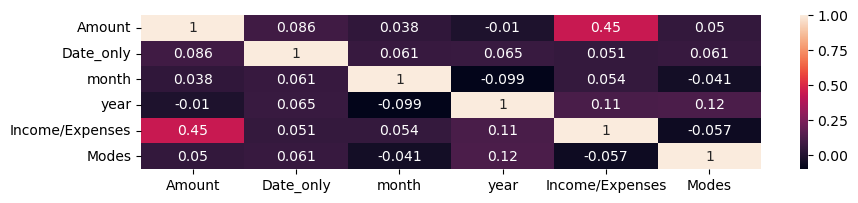

23/09/24 23:21:34 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 995043 ms exceeds timeout 120000 ms
23/09/24 23:21:34 WARN SparkContext: Killing executors is not supported by current scheduler.
23/09/24 23:21:39 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

23/09/24 23:21:49 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/24 23:21:59 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/24 23:57:05 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 00:29:13 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 01:02:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 01:33:43 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 02:04:37 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 02:38:59 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 03:13:51 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 03:45:49 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 04:20:39 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 04:37:00 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 05:10:46 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 05:26:43 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 05:26:53 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 06:01:39 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 06:33:03 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 06:35:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 06:52:43 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 07:26:32 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 08:00:15 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 08:15:37 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 08:38:19 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 08:55:06 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 08:55:16 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 08:55:26 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 08:55:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 08:55:56 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 09:08:07 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 09:08:17 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 09:08:27 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 09:08:37 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 09:08:47 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 09:08:57 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 09:25:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:00:39 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:04:26 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 10:08:23 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 10:08:43 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:08:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:09:03 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 10:09:13 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:09:23 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:09:33 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 10:09:43 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:09:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:10:03 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:10:13 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 10:10:23 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:10:33 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:10:43 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:10:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:11:03 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:11:13 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:11:23 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/09/25 10:11:33 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/09/25 10:11:43 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 61568)
Traceback (most recent call last):
  File "/Users/nithinkumar/anaconda3/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/nithinkumar/anaconda3/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/nithinkumar/anaconda3/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/nithinkumar/anaconda3/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/nithinkumar/anaconda3/lib/python3.10/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/Users/nithinkumar/anaconda3/lib/python3.10/site-packages/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/Users/n

In [83]:
plt.figure(figsize=(10,2))
sns.heatmap(df_pd.corr(),annot=True)